# 1. Tipos de fronteras en Clasificación

Primero, se generan los conjuntos de datos con los que se analizarán las distintas fronteras y algoritmos a utilizar

In [1]:
# Generacion de los datos para analisis
from sklearn.utils import check_random_state
import matplotlib.patches as mpatches
import numpy as np


def build_data(seed, noise_seed=64, n_samples=500, noise=20):
    n_samples=500
    mean = (0,-4)
    C = np.array([[0.3, 0.1], [0.1, 1.5]])
    np.random.seed(seed)
    datos1 = np.random.multivariate_normal(mean, C, n_samples)
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
    datos2 = np.vstack((outer_circ_x,outer_circ_y)).T

    generator = check_random_state(noise_seed)
    datos2 += generator.normal(scale=0.3, size=datos2.shape)

    X = np.concatenate((datos1, datos2), axis=0)
    n = noise #ruido/noise
    y1 = np.zeros(datos1.shape[0]+n)
    y2 = np.ones(datos2.shape[0]-n)
    y = np.concatenate((y1,y2),axis=0)
    return (X, y)

(X, y) = build_data(14)
(Xtest, ytest) = build_data(8000, noise_seed=7000)

A continuación, se visualizan brevemente los datos

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


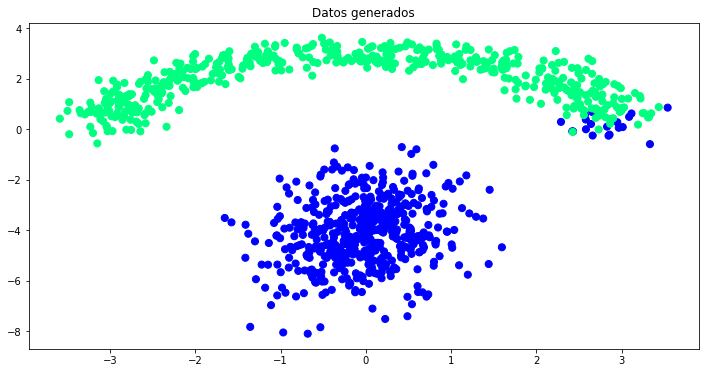

In [2]:
# Se grafican los datos obtenidos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:,1], s=50, c=y, cmap=plt.cm.winter)
plt.title('Datos generados')
plt.show()

A continuación se define una función para visualizar la frontera que divide a los datos dado un modelo entrenado con el objeto de rápidamente ver los bordes de decisión encontrados por los distintos algoritmos


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def visualize_border(model,x,y, title="", x_test=None, y_test=None):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    if x_test is not None and y_test is not None:
        y_train_pred = model.predict(x)
        y_test_pred = model.predict(x_test)
        train_error = (1-accuracy_score(y, y_train_pred))
        test_error = (1-accuracy_score(y_test, y_test_pred))
        red_patch = mpatches.Patch(color='red', label="Train ME: %f" % train_error)
        green_patch = mpatches.Patch(color='green', label="Test ME: %f" % test_error)
        plt.legend(handles=[red_patch, green_patch])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

### Linear Discriminant Analysis (LDA)

A continuación se entrena un modelo usando LDA. Este algoritmo asume que la función de densidad de cada clase es gaussiana y que además existe una matriz de covarianza $\Sigma$ igual entre las clases.

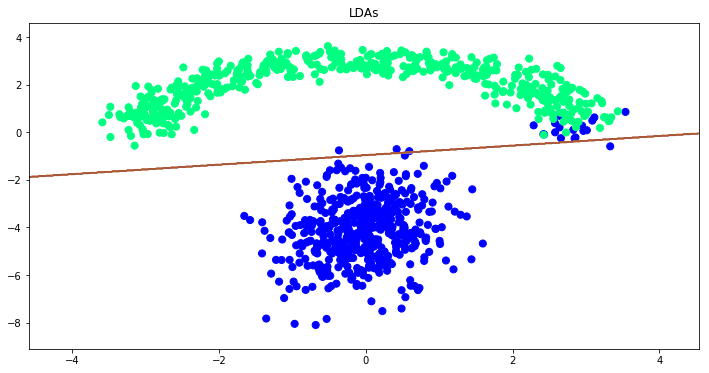

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_LDA = LDA()
model_LDA.fit(X,y)
visualize_border(model_LDA,X,y,"LDAs")

Con un error de clasificación de entrenamiento igual a:

In [5]:
1-model_LDA.score(X, y)

0.02200000000000002

Y con un error de clasificación de testing igual a:

In [6]:
1-model_LDA.score(Xtest, ytest)

0.02300000000000002

### Quadratic Discriminant Analysis (QDA)

A continuación se entrena un modelo usando QDA. Este algoritmo, al igual que LDA, asume que la densidad de los datos siguen distribuciones gaussianas, buscando encontrar la frontera que maximice la distancia entre dos distribuciones. A diferencia de **LDA**, QDA no asume nada respecto a las matrices de covarianza de dichas distribuciones.

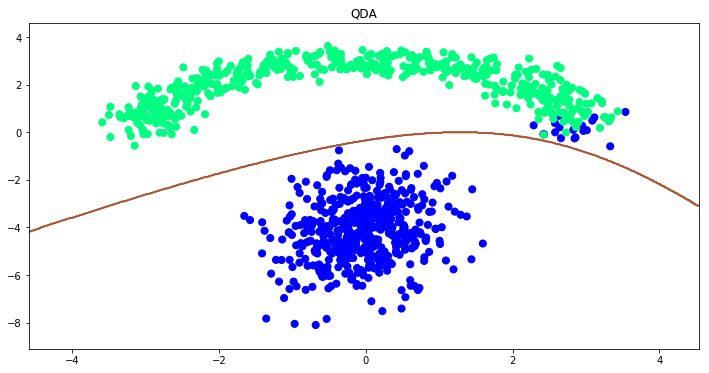

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model_QDA = QDA()
model_QDA.fit(X,y)
visualize_border(model_QDA,X,y,"QDA")

Con un error de entrenamiento igual a:

In [8]:
1-model_QDA.score(X, y)

0.020000000000000018

Y un error de testing igual a:

In [9]:
(Xtest, ytest) = build_data(8000, noise_seed=7000)
1-model_LDA.score(Xtest, ytest)

0.02300000000000002

### QDA v/s LDA


##### Diferencia cualitativa y teórica

La principal diferencia entre QDA y LDA se puede visualizar en las secciones anteriores en donde se puede observar claramente que las fronteras calculadas por LDA son lineales, mientras que las de QDA y en honor a su nombre son cuadráticas.

##### Diferencia cuantitativa

A continuación se presentan los errores de clasificación para ambos modelos

In [10]:
from sklearn.metrics import accuracy_score

y_pred_LDA = model_LDA.predict(X)
y_pred_QDA = model_QDA.predict(X)
print("Miss Classification Loss for LDA: %f"%(1-accuracy_score(y, y_pred_LDA)))
print("Miss Classification Loss for QDA: %f"%(1-accuracy_score(y, y_pred_QDA)))

Miss Classification Loss for LDA: 0.022000
Miss Classification Loss for QDA: 0.020000


Se puede apreciar que, en este caso particular, es QDA el que tiene mejor rendimiento en comparación a LDA. Esto no sorprende debido a la naturaleza de la distribución de los datos que hacen a **QDA** un mejor estimador.

### Logistic Regression

A continuación se define una función para graficar las fronteras seleccionadas por cada máquina permitiendo la interacción con distintos parámetros.

In [11]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y,x_test=Xtest,y_test=ytest)


Se entrena un modelo de regresión logística regularizado con la normal $l_2$

In [12]:
from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X,y)
    return model

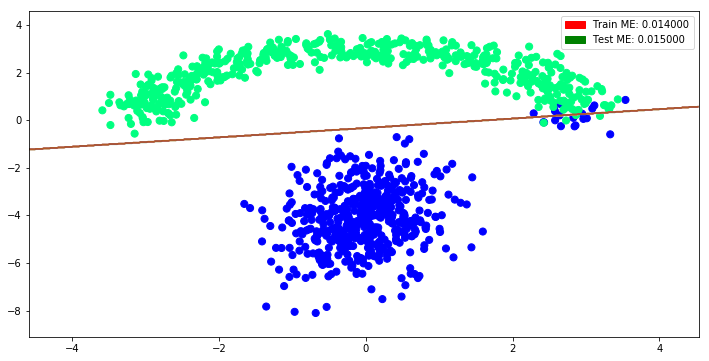

In [13]:


p_min_lr = 0.001
p_max_lr = 1
interactive(visualize_border_interactive,param=(p_min_lr,p_max_lr, 0.001))

El parámetro $C$ es un parámetro de regularización que actua como el inverzo de la fuerza de regularización para la norma $l_2$ en donde valores cercanos a $1.0$ indican ausencia de regularización y valores cercanos a $0.0$ indican la máxima posible fuerza de regularización.

Cuando hay alta regularización, aumenta el número de outliers que son ignorados durante el entrenamiento.

### SVM Lineal

El método de SVM (Support Vector Machine) busca una frontera de decisión maximizando el margen entre las distintas clases o labels del conjunto de datos, procurando a la vez clasificar la mayor cantidad de datos en el conjunto de entrenamiento correctamente. Existe un hiperparámetro que mide el tradeoff entre la maximización del margen y el error de entrenamiento que es generalmente denotado por C

Se construye el siguiente gráfico con la frontera seleccionada por una SVM de tipo lineal

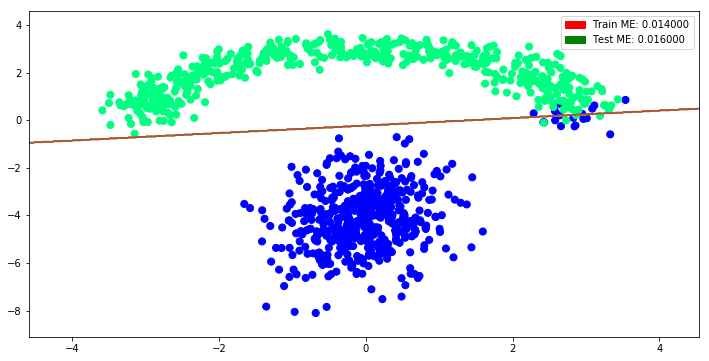

In [14]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X,y)
    return model

p_min_svm_linear = 0.001
p_max_svm_linear = 1
interactive(visualize_border_interactive,param=(p_min_svm_linear,p_max_svm_linear, 0.001))

De manera teórica, el parametro **$C$** en la SVM lineal controla el tradeoff entre maximizar el margen entre las dos clases y minimizar el error de clasificación del conjunto de entrenamiento (considerando una función objetivo dada por $CA+B$ y en dónde la constante está dada generalmente por $C = \frac{1}{\lambda}$). Si se utilizan valores de $C$ grandes, el modelo de SVM lineal intentará con más fuerza clasificar correctamente los puntos de entrenamiento, lo que disminuye la maximización del margen y lleva a posible overfitting.

Se puede observar en el gráfico interactivo que para un valor de $C$ cercano a 0, se tiene una frontera que clasifica menos puntos de la clase $AZUL$, mientras que valores cercanos a 1 consideran mayor puntos de la clase $AZUL$. Esto es esperado considerando el significado del parámetro $C$.

### SVM No lineal

En el método de SVM no lineal, se utilizan kernels que realizan transformaciones al espacio original de datos a nuevos espacios en donde sea posible tener fronteras linealmente separables. El ejemplo clásico es cuando la frontera es de tipo circular. En este caso, se necesita utilizar un método de kernel para llevar a un espacio lineal a los datos. En este caso, una transformación teórica podria ser $z = x^2 + y^2$ que transforma el espacio euclidiano original en un espacio de coordenadas poalres. Aquí, si es posible encontrar una frontera linealmente separable.

A continuación se exploran las fronteras de decisión de distintos kernels (por tanto, supuestos de transformaciones distintos) sujetos a distintos valores del parámetro C. Estos kernels producen fronteras que no son lineales en el espacio original de los datos.

##### Kernel de función radial base o Radial basis function (RBF)

Explicación de que transformación usa este kernel

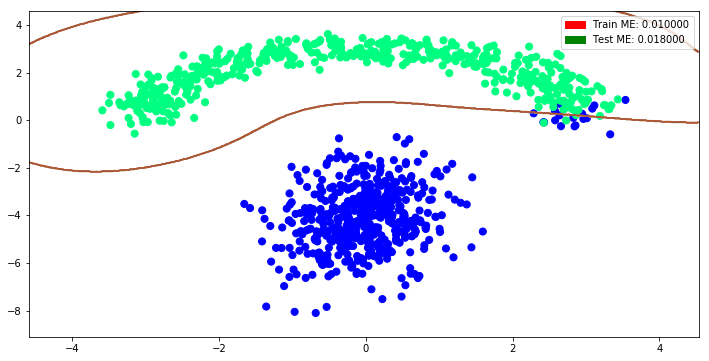

In [15]:

from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='rbf')
    model.fit(X,y)
    return model

p_min_svm_rbf = 0.001
p_max_svm_rbf = 1
interactive(visualize_border_interactive,param=(p_min_svm_rbf,p_max_svm_rbf, 0.001))



##### Kernel polinomial

explicación de kernel

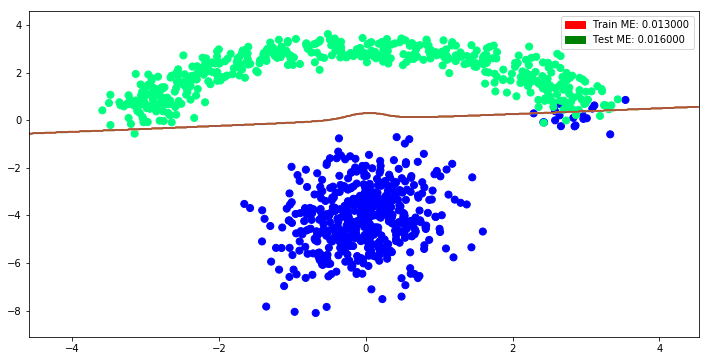

In [16]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='poly')
    model.fit(X,y)
    return model

p_min_svm_poly = 0.001
p_max_svm_poly = 1
interactive(visualize_border_interactive,param=(p_min_svm_poly,p_max_svm_poly, 0.001))

#### Kernel sigmoidal

explicación de kernel

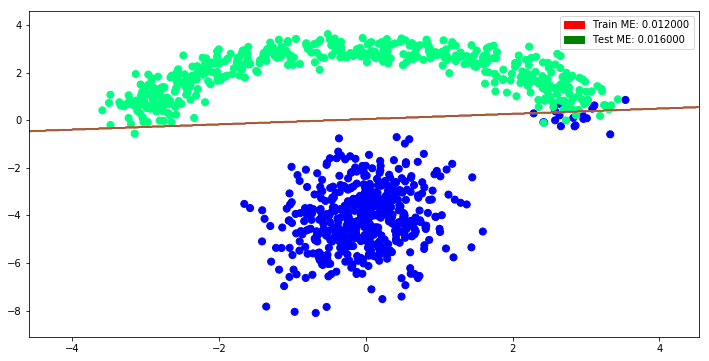

In [17]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='sigmoid')
    model.fit(X,y)
    return model

p_min_svm_sigmoid = 0.001
p_max_svm_sigmoid = 1
interactive(visualize_border_interactive,param=(p_min_svm_sigmoid,p_max_svm_sigmoid))

### Árbol de decisión

Los árboles de decisión dividen el espacio de los atributos en subconjuntos con el fin de utilizar la heurística de dividir y conquistar, que es ampliamente utilizada en la cienca de la computación.

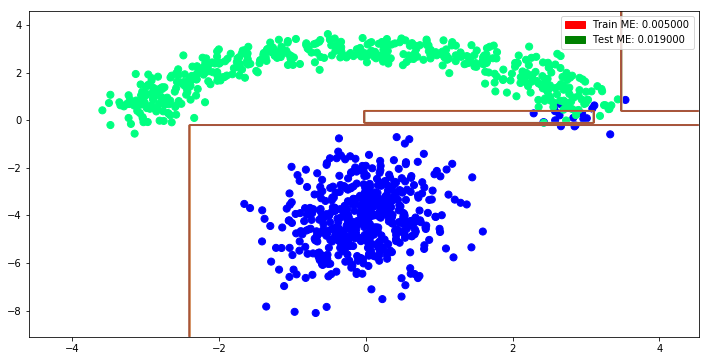

In [18]:
from sklearn.tree import DecisionTreeClassifier as Tree

def train_model(param):
    model = Tree() #edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X,y)
    return model

p_tree_min = 1
p_tree_max = 10
interactive(visualize_border_interactive,param=(p_tree_min,p_tree_max))


### Clasificador de vecino más cercano

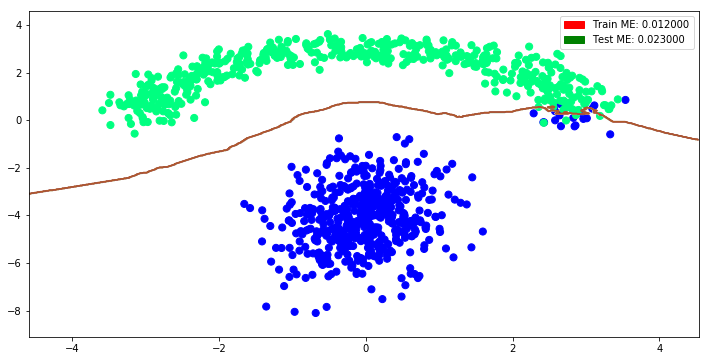

In [19]:
from sklearn.neighbors import KNeighborsClassifier

def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X,y)
    return model

p_tree_min = 1
p_tree_max = 10
interactive(visualize_border_interactive,param=(p_tree_min,p_tree_max))


# 2. Análisis de audios como datos brutos

Primero se definen las funciones necesarias para poder realizar la lectura de los archivos de audio

In [20]:
from scipy.io import wavfile

SAMPLE_RATE = 44100

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name


def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

Luego, se lee el conjunto de datos disponible y se presenta

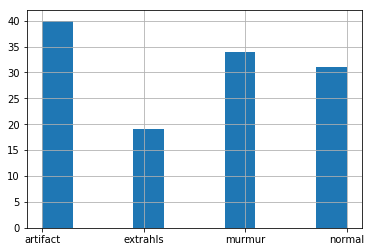

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('./heartbeat-sounds/set_a.csv')
df['label'].hist()
plt.show()

B) Lea los archivos .wav y transformelos en secuencias de tiempo. Realice un padding de ceros al final de cada secuencia para que todas queden representadas con la misma cantidad de elementos, explique la importancia de realizar este paso.


In [22]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux
new_df = pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='./heartbeat-sounds/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))
new_df.head()

,file_name,time_series,len_series
0,artifact__201012172012.wav,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,artifact__201105040918.wav,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,artifact__201105041959.wav,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,artifact__201105051017.wav,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,artifact__201105060108.wav,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


C) Manipule los datos y cambie las etiquetas de los audios por otras asignadas por un doctor experto [4], el cual afirma que estos cambios son requeridos. Vuelva a determinar cu ́antos registros hay por clase. N ́otese que ahora son 3 clases ¿Explique la problem ́atica de tener etiquetas mal asignadas en los datos? ¿Un solo dato puede afectar esto?

In [23]:
new_labels=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,2,1,1,1,2,2,2,1,1,2,1,2,2,1,2,2,2,2,2,2,
    2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,
    1,2,1,1,1,1,1,2,1,1,1,1,1,1,1,2,2,1,1,1,1,1,2,1,0,
    2,2,1,1,1,1,1,0,1,0,1,1,1,2,1,0,1,1,1,1,1,2,0,0,0,
    0,0,0,0,1,0,0,0,0,0,0,1,0,2,1,2,2,2,2,2,2,2,2,2,2, 2]
labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

D) Codifique las distintas clases a valores num ́ericos para que puedan ser trabajados por los algoritmos clasificadores.

In [24]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)

E) Desordene los datos, evitando as ́ı el orden en el que vienen la gran mayor ́ıa de las etiquetas. Cree la matriz que conforma a los datos en sus dimensiones sin preprocesar, es decir, cada ejemplo es una secuencia de amplitudes en el tiempo. ¿Las dimensiones de  ́esta indica que puede generar problemas? ¿De qu ́e tipo?

In [25]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape
X

array([[  -85.,  -198.,  -214., ...,  -110.,   -74.,   -76.],
       [   96.,    90.,    84., ...,     0.,     0.,     0.],
       [  220.,   191.,   171., ...,     0.,     0.,     0.],
       ..., 
       [  376.,   413.,   429., ...,     0.,     0.,     0.],
       [ -404.,  -442.,  -456., ...,     0.,     0.,     0.],
       [-2169., -2661., -1605., ...,   435.,   373.,   417.]])

F) Para pre procesar la secuencia en el tiempo realice una transformada de fourier discreta [5] para pasar los datos desde el dominio de tiempos al dominio de frecuencias presentes en la señal de sonido.

In [26]:
X_fourier = np.abs(np.fft.fft(X))

G) Para seguir con el pre procesamiento realice un muestreo representativo de los datos a trav ́es de una t ́ecnica de muestreo especializada en secuencias ¿En qu ́e beneficia este paso? ¿C ́omo podr ́ıa determinar si el muestro es representativo?

In [27]:
from scipy import signal
X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)
X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

H) Genere un conjunto de pruebas mediante la t ́ecnica hold-out validation para verificar la calidad de los clasificadores. ¿Cu ́antas clases tiene y de qu ́e taman ̃o queda cada conjunto?

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)

I) Realice un proceso de estandarizar los datos para ser trabajados adecuadamente. Recuerde que solo se debe ajustar (calcular media y desviaci ́on est ́andar) con el conjunto de entrenamiento.

In [29]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

J) Realice una reducci ́on de dimensionalidad a trav ́es de la t ́ecnica PCA, para representar los datos en d = 2 dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyecci ́on en 2 dimensiones.

In [30]:
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

K) Entrene un modelo de Regresi ́on Log ́ıstica variando el par ́ametro de regularizacion C construyendo un gr ́afico resumen del error en funci ́on de este hiper-par ́ametro. Adem ́as entrene una M ́aquina de Soporte Vectorial (SVM) con kernel lineal, variando el hiper-par ́ametro de regularizacion C en el mismo rango que para la Regresi ́on Log ́ıstica, construyendo el mismo gr ́afico resumen. Compare.

In [31]:
Cs = [0.0001,0.01,0.1,1,10,100,1000]

L) Entrene un A ́rbol de Decisi ́on, con la configuraci ́on que estime conveniente, variando el hiper-par ́ametro regularizador max depth, construyendo un gr ́afico resumen del error en funci ́on de este par ́ametro. Compare con los modelos anteriores.

In [32]:
Depths = range(1,30)

M) Experimente con diferentes dimensiones d para la proyecci ́on de PCA con el prop ́osito de obtener un
modelo con menor error. Construya una tabla o gr ́afico resumen.


N) Realice otra reducci ́on de dimensionalidad ahora a trav ́es de la t ́ecnica LDA, para representar los datos en d = 2 dimensiones. Recuerde que s ́olo se debe ajustar con el conjunto de entrenamiento, si se muestra un warning explique el porqu ́e. Visualice apropiadamente la proyecci ́on en 2 dimensiones.

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_pca_train = model_lda.transform(X_train)
X_pca_test = model_lda.transform(X_test)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

O) Con el prop ́osito de encontrar el mejor modelo vuelva a realizar el item h) con el i) en el nuevo espacio generado por la representaci ́on segu ́n las d dimensiones de la proyecci ́on LDA. Esta nueva representaci ́on ¿mejora o empeora el desempen ̃o? Explique.

P) Intente mejorar el desempen ̃o de los algoritmos ya entrenados. Disenñe ahora sus propias cracteríticas (feature crafting) a partir de los datos brutos (secuencia de amplitudes), puede inspirarse en otros trabajos (https://www.kaggle.com/primaryobjects/voicegender/data
) (Gamit, M. R., Dhameliya, P. K., & Bhatt, N. S. (2015). Classification Techniques for Speech Recognition: A Review. vol, 5, 58-63.
) si desea

# 3. Análisis de emociones en tweets

**a)** Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [34]:
import pandas as pd
tweets = pd.read_csv('./data/text_emotion.csv')
tweets.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [35]:
clases = pd.DataFrame(tweets['sentiment'].value_counts().reset_index())
clases.columns = ["sentiment", "count"]
clases

,sentiment,count
0,neutral,8638
1,worry,8459
2,happiness,5209
3,sadness,5165
4,love,3842
5,surprise,2187
6,fun,1776
7,relief,1526
8,hate,1323
9,empty,827


El dataset cuenta con cuatro columnas, las que corresponden a el id del tweet, el autor y el contenido de este, junto con el sentimiento asociado al contenido.
Los sentimientos encontrados son 13, contando "neutral" como uno de ellos.

**b)** Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos.

La máscara se aplicará después de pre-procesar el dataset y antes de entrenar el clasificador

**c)** Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato estándarizado en el cual se podrán trabajar.

In [36]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felipemorales/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felipemorales/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
df = tweets.copy()

ps = PorterStemmer()
sw = stopwords.words('english')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

df['norm_content'] = df['content'].apply(lambda x: tknzr.tokenize(x.lower()))
df['norm_content'] = df['norm_content'].apply(lambda x: [w for w in x if (w not in sw and len(w)>2)])
df['norm_content'] = df['norm_content'].apply(lambda x: [ps.stem(w) for w in x])
df.head()

,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,"[funer, ceremoni, ..., gloomi, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"


Ahora se hace la separación de test - train

In [38]:
import numpy as np
np.random.seed(14)
msk = np.random.rand(len(df)) < 0.8

# manual preprocess
df_train = df[msk].copy()
df_test = df[~msk].copy()

# default countvector preprocess
df_train_df = df[msk].copy()

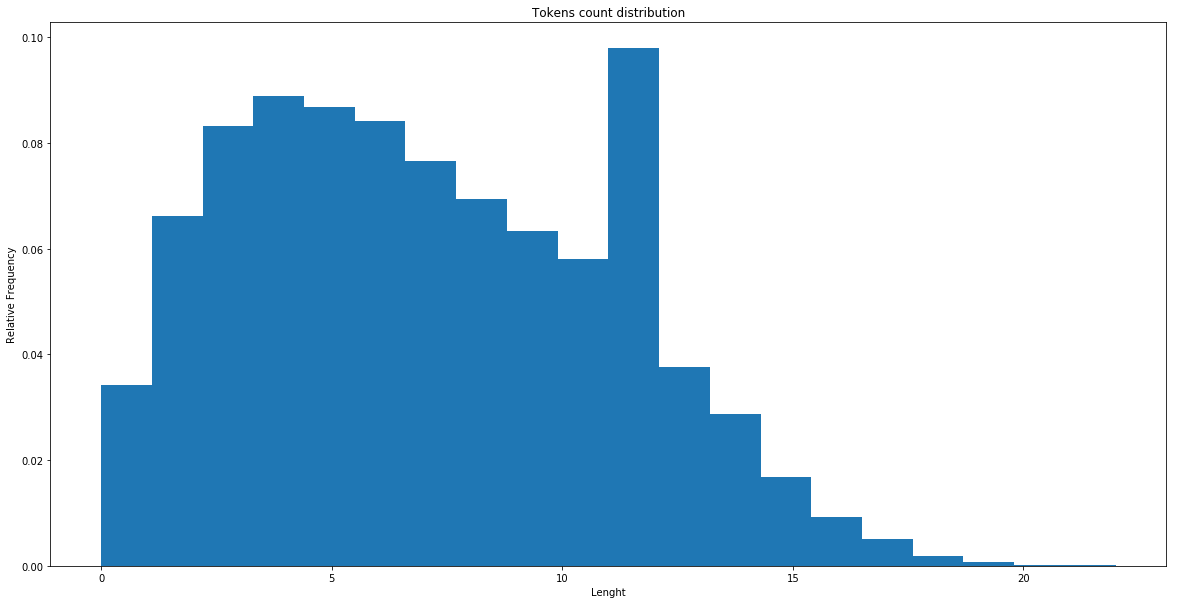

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
gaussian_numbers = df_train['norm_content'].map(len)
plt.hist(gaussian_numbers, bins=20, normed=True)
plt.title("Tokens count distribution")
plt.xlabel("Lenght")
plt.ylabel("Relative Frequency")
plt.show()

In [40]:
df_train = df_train[df_train['norm_content'].map(len) > 1]
df_train = df_train[df_train['norm_content'].map(len) < 14]
df_train.head()

,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ...","[sleep, think, old, friend, want, he', marri, ..."


**d)** Haga una reducción binaria al problema, para trabajarlo como un problema de clasificación de dos clases. Para esto, agrupe las distintas emociones como positivas y negativas (defina un criterio), se recomienda codificar las clases como +1 y −1 respectivamente. Recuerde tener presente que el desbalanceo de los datos puede afectar considerablemente al modelo.

In [41]:
pos = ['neutral', 'happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm']

df_train['clase'] = df_train['sentiment'].apply(lambda x: 1 if x in pos else -1)
df_train_df['clase'] = df_train_df['sentiment'].apply(lambda x: 1 if x in pos else -1)

df_test['clase'] = df_test['sentiment'].apply(lambda x: 1 if x in pos else -1)

print(df_train_df['clase'].value_counts()+df_test['clase'].value_counts())
df.head()

 1    23937
-1    16063
Name: clase, dtype: int64


,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,"[funer, ceremoni, ..., gloomi, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"


**e)** Construir un clasificador que determine automáticamente la polaridad de un trozo de texto.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

def echo(args):
    return args

# Pre-proceso propio
vectorizer = CountVectorizer(tokenizer=echo, preprocessor=echo, lowercase=False)
X_train = vectorizer.fit_transform(df_train['norm_content'])
X_test = vectorizer.transform(df_test['norm_content'])

# Pre-proseso por default de CountVectorizer
vectorizer_df = CountVectorizer()
X_train_df = vectorizer_df.fit_transform(df_train_df['content'])
X_test_df = vectorizer_df.transform(df_test['content'])

**f)** Entrene y compare al menos 5 de los diferentes clasificadores vistos en clases para clasificación binaria (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logística, SVM y Arboles de decisión) sobre el conjunto de entrenamiento verificando su desempeño sobre ambos conjuntos (entrenamiento y de pruebas), construyendo un gráfico resumen del error de éstos.

In [43]:
def train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    return (model, score_train, score_test)

In [44]:
from sklearn.naive_bayes import BernoulliNB
naive_bayes = train(BernoulliNB(), X_train, df_train['clase'], X_test, df_test['clase'])
naive_bayes_df = train(BernoulliNB(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("Naive Bayes scores:    \t train: %.3f \t test: %.3f"%(naive_bayes[1],naive_bayes[2]))
print("Naive Bayes df scores: \t train: %.3f \t test: %.3f"%(naive_bayes_df[1],naive_bayes_df[2]))

Naive Bayes scores:    	 train: 0.820 	 test: 0.708
Naive Bayes df scores: 	 train: 0.840 	 test: 0.697


In [45]:
from sklearn.naive_bayes import MultinomialNB
multi_naive_bayes = train(MultinomialNB(), X_train, df_train['clase'], X_test, df_test['clase'])
multi_naive_bayes_df = train(MultinomialNB(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("Multi Naive Bayes scores:    \t train: %.3f \t test: %.3f"%(multi_naive_bayes[1],multi_naive_bayes[2]))
print("Multi Naive Bayes df scores: \t train: %.3f \t test: %.3f"%(multi_naive_bayes_df[1],multi_naive_bayes_df[2]))

Multi Naive Bayes scores:    	 train: 0.825 	 test: 0.711
Multi Naive Bayes df scores: 	 train: 0.863 	 test: 0.710


In [46]:
from sklearn.linear_model import LogisticRegression
logistic = train(LogisticRegression(), X_train, df_train['clase'], X_test, df_test['clase'])
logistic_df = train(LogisticRegression(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("LogisticRegression scores:    \t train: %.3f \t test: %.3f"%(logistic[1],logistic[2]))
print("LogisticRegression df scores: \t train: %.3f \t test: %.3f"%(logistic_df[1],logistic_df[2]))

LogisticRegression scores:    	 train: 0.840 	 test: 0.717
LogisticRegression df scores: 	 train: 0.884 	 test: 0.718


In [47]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = train(DecisionTreeClassifier(), X_train, df_train['clase'], X_test, df_test['clase'])
decision_tree_df = train(DecisionTreeClassifier(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("DecisionTree scores:    \t train: %.3f \t test: %.3f"%(decision_tree[1],decision_tree[2]))
print("DecisionTree df scores: \t train: %.3f \t test: %.3f"%(decision_tree_df[1],decision_tree_df[2]))

DecisionTree scores:    	 train: 0.997 	 test: 0.667
DecisionTree df scores: 	 train: 0.999 	 test: 0.657


In [48]:
from sklearn.linear_model import SGDClassifier
gradient_descent = train(SGDClassifier(max_iter=5,tol=None), X_train, df_train['clase'], X_test, df_test['clase'])
gradient_descent_df = train(SGDClassifier(max_iter=5,tol=None), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("SGD scores:    \t train: %.3f \t test: %.3f"%(gradient_descent[1],gradient_descent[2]))
print("SGD df scores: \t train: %.3f \t test: %.3f"%(gradient_descent_df[1],gradient_descent_df[2]))

SGD scores:    	 train: 0.809 	 test: 0.713
SGD df scores: 	 train: 0.820 	 test: 0.703


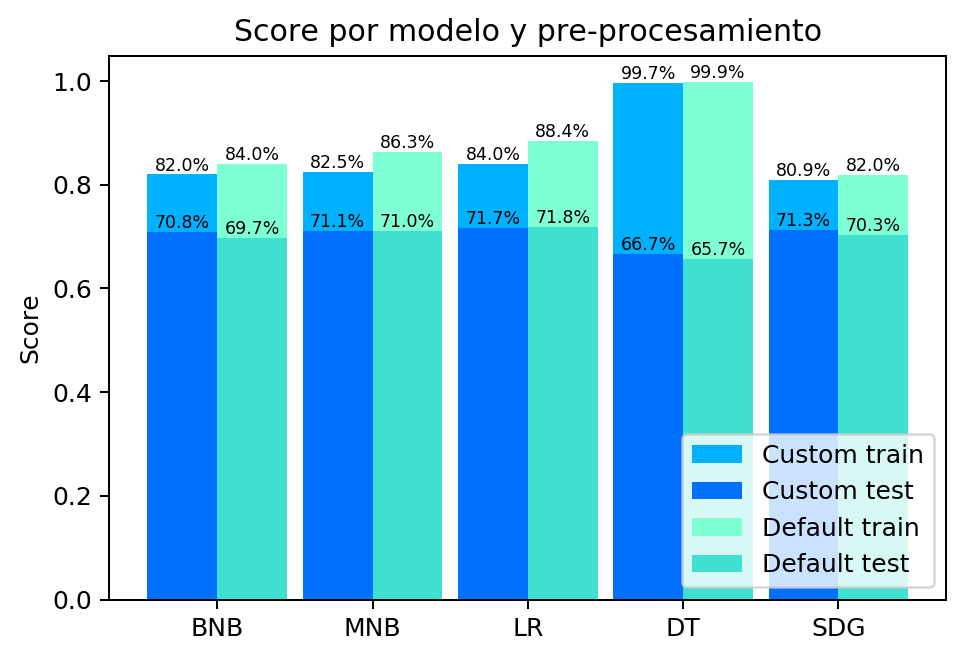

In [49]:
import matplotlib.pyplot as plt
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.45       # the width of the bars

fig, ax = plt.subplots()

test_scores = (naive_bayes[1], multi_naive_bayes[1], logistic[1], decision_tree[1], gradient_descent[1])
train_scores = (naive_bayes[2], multi_naive_bayes[2], logistic[2], decision_tree[2], gradient_descent[2])

rects1 = ax.bar(ind, test_scores, width, color='#00b1ff')
rects1b = ax.bar(ind, train_scores, width, color='#0070ff')

test_scores_df = (naive_bayes_df[1], multi_naive_bayes_df[1], logistic_df[1], decision_tree_df[1], gradient_descent_df[1])
train_scores_df = (naive_bayes_df[2], multi_naive_bayes_df[2], logistic_df[2], decision_tree_df[2], gradient_descent_df[2])

rects2 = ax.bar(ind + width, test_scores_df, width, color='#7fffd4')
rects2b = ax.bar(ind + width, train_scores_df, width, color='#40e0d0')

# add some text for labels, title and axes ticks
ax.set_ylabel('Score')
ax.set_title('Score por modelo y pre-procesamiento')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('BNB', 'MNB', 'LR', 'DT', 'SDG'))

ax.legend((rects1[0], rects1b[0], rects2[0], rects2b[0]), ('Custom train', 'Custom test', 'Default train', 'Default test'), loc='lower right')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%.1f%%' % (100*height),
                ha='center', va='bottom', fontsize = 'x-small')

autolabel(rects1)
autolabel(rects1b)
autolabel(rects2)
autolabel(rects2b)
fig.set_dpi(180)

plt.show()

**g)** Utilice y explique las métricas que calcula la función classification report de la librería sklearn. En base a las distintas métricas calculadas ¿Cuáles clasificadores son los que mejor se comportan?

In [50]:
from sklearn.metrics import classification_report
def score_report(model, X, y, name):
    acc_tr = model[1]
    acc_test = model[2]
    print("Scores for "+name+":")
    print("\tTraining Accuracy: %f"%(acc_tr))
    print("\tTest Accuracy: %f"%(acc_test))
    print("\tDetailed Analysis Testing Results ...")
    print(classification_report(y, model[0].predict(X), target_names=['+','-']))
    print("")

In [51]:
score_report(naive_bayes, X_test, df_test['clase'], "BNB")
score_report(multi_naive_bayes, X_test, df_test['clase'], "MNB")
score_report(logistic, X_test, df_test['clase'], "LR")
score_report(decision_tree, X_test, df_test['clase'], "DT")
score_report(gradient_descent, X_test, df_test['clase'], "SGD")

Scores for BNB:
	Training Accuracy: 0.820020
	Test Accuracy: 0.708427
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.68      0.51      0.59      3218
          -       0.72      0.84      0.78      4804

avg / total       0.70      0.71      0.70      8022


Scores for MNB:
	Training Accuracy: 0.824849
	Test Accuracy: 0.710795
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.66      0.59      0.62      3218
          -       0.74      0.79      0.77      4804

avg / total       0.71      0.71      0.71      8022


Scores for LR:
	Training Accuracy: 0.840174
	Test Accuracy: 0.716779
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.68      0.55      0.61      3218
          -       0.73      0.83      0.78      4804

avg / total       0.71      0.72      0.71      8022


Scores for DT:
	Training A

**h)** [Opcional] Visualice las predicciones de algún modelo generativo (probabilístico) definido anteriormente, tomando un subconjunto aleatorio de tweets de pruebas y explorando las probabilidades que asigna el clasificador a cada clase.

In [52]:
import random
random.seed(14)
test_pred = logistic[0].predict_proba(X_test)
spl = random.sample(range(len(test_pred)), 15)

print("Negative \t Positive \t Tweet")
for i in spl:
    print(test_pred[i],"\t",df_test.reset_index()['content'][i])

Negative 	 Positive 	 Tweet
[ 0.54432601  0.45567399] 	 On my way to work wish I had more days off
[ 0.24291798  0.75708202] 	 @AprilAMiller Its 5:30 in the evening, sunset time
[ 0.30682156  0.69317844] 	 @mamapigeon I be ok, you?
[ 0.15008244  0.84991756] 	 watchin family guy
[ 0.09633013  0.90366987] 	 @BeSharp wow, great to know a piece of software ensures our timely project delivery  #ProductNamingRulez
[ 0.13828451  0.86171549] 	 @rachky @taltalush Yes. I am secure in my masculinity.
[ 0.14690876  0.85309124] 	 @issacfourth haha dork .. That sounds so yummy .. Share!
[ 0.17926191  0.82073809] 	 @cowmage  read something happy?
[ 0.87789726  0.12210274] 	 Ugh just got out of work i think i'm a dang taxi for ppl but i just can't say no!!!!  o well its my fault
[ 0.75048263  0.24951737] 	 @yourself_onfire I think Letitia is still trying to upload the digital, they were having problems before. I am sure she will let us know
[ 0.61455877  0.38544123] 	 http://twitpic.com/675u6 - Square

**i)** Ahora deberá extender el problema a las múltiples clases que tiene presente (las distintas emociones), es decir, su trabajo será el de predecir una de las distintas emociones de cada _tweet_. Para esto utilice el mismo pre-procesamiento realizado en el punto c) y las características generadas mediante las técnicas en el punto e). Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros.

In [53]:
clases['value']=[0,-1,1,-2,2,3,4,5,-3,-4,6,-5,-6]
sent = list(clases['sentiment'])
sent_v = list(clases['value'])
df_train['sentiment_class'] = df_train['sentiment'].apply(lambda x: sent_v[sent.index(x)])
df_test['sentiment_class'] = df_test['sentiment'].apply(lambda x: sent_v[sent.index(x)])

df_train.head()

,tweet_id,sentiment,author,content,norm_content,clase,sentiment_class
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f...",-1,-4
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call...",-1,-2
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]",1,6
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]",1,0
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ...","[sleep, think, old, friend, want, he', marri, ...",-1,-2


In [54]:
from sklearn.naive_bayes import MultinomialNB
multi_naive_bayes = train(MultinomialNB(), X_train, df_train['sentiment'], X_test, df_test['sentiment'])

print("Multi Naive Bayes scores:    \t train: %.3f \t test: %.3f"%(multi_naive_bayes[1],multi_naive_bayes[2]))

Multi Naive Bayes scores:    	 train: 0.531 	 test: 0.322


**j)** Utilice los clasificadores que son extendidos por defecto a múltiples clases para detectar emociones en cada _tweet_, muestre sus desempeños a través del error de pruebas en un gráfico resumen.

**k)** Utilice clasificadores binarios que pueden ser extendidos a través de otras técnicas, tal como One vs One y One vs All/Rest.

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
#example
classif = OneVsRestClassifier(model)
classif.fit(X, Y)

NameError: name 'model' is not defined

**l)** Para el caso de la Regresión Logística compare sus dos métodos para ser extendidos a múltiples clases. Uno a través de One vs Rest y otro definiendo que la variable a predecir se distribuye Multinomial.

**m)** Compare los resultados entre los clasificadores extendidos por defecto y los binarios que son extendidos mediante otras técnicas, construya una tabla o gráfico resumen. Los clasificadores que mejor se comportan en el caso binario ¿Siguen teniendo ese desempeño en múltiples clases?